In [1]:
# This is to test the desi SV3 setup and how to define the jackknife for Rosette

In [1]:
#Create a file to list all the parameters of cosmology in Abacus simulation
from __future__ import print_function

#####importing the necessary libraries
#To make the plots inline otherwise it will make seperate figure
%matplotlib inline 
#for high resolution plot outputs
%config InlineBackend.figure_format = 'retina'

import numpy as np

import os
import sys

#latex display
from IPython.display import Latex

import fitsio as F

####plottinng library and setting
import pylab as pl
import matplotlib
matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})
wdir='../jnk/'


from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(ticks=True, grid=False, figsize=(10, 8))

# reset default matplotlib rcParams
jtplot.reset()

In [2]:
def load_tile(tile_file):
    
    dtype_dic={'int':['TILEID', 'PASS' ],
               'bool':['IN_DESI',    'AVAILABLE'],
              'float':['RA', 'DEC','PRIORITY','EBV_MED','DESIGNHA', 'DONEFRAC'],
              'str':['PROGRAM','STATUS']}
    
    tlines=open(tile_file).readlines()
    tile={}
    for tt,tline in enumerate(tlines):
        if(tline[0]=='#'):
            continue

        if(tile=={}):
            head=tline.split()
            for hh in head:
                tile[hh]=[]
            continue

        tspl=tline.split()
        for hh,th in enumerate(head):
            if(th in dtype_dic['int']):
                tile[th].append(np.int(tspl[hh]))
            elif(th in dtype_dic['bool']):
                tile[th].append(np.bool(tspl[hh]))
            elif(th in dtype_dic['float']):
                tile[th].append(np.float(tspl[hh]))
            else:
                tile[th].append(tspl[hh])

    for hh,th in enumerate(head):
        tile[th]=np.asarray(tile[th])

    return tile

def club_tiles_by_Rosette(tiles,program='DARK'):
    '''Algo: select all the tiles in pass0,
    This define the unique Rosette,\n",
    find all tiles within few small seperation (0.5) of tile in pass0
    They all belong to same Rosette'''

    #choose a program
    indprog=np.where(tiles['PROGRAM']==program)[0]

    indsel=np.where(tiles['PASS']==0)[0]

    rosette={}
    rose_id=-1
    for ii in range(0,indsel.size):
        if(indsel[ii] not in indprog):
            continue
        rose_id=rose_id+1   
        rosette[rose_id]={'tiles':[tiles['TILEID'][indsel[ii]]]}
        diff=np.sqrt(np.power(tiles['RA']-tiles['RA'][indsel[ii]],2)+np.power(tiles['DEC']-tiles['DEC'][indsel[ii]],2))
        ind_this=np.where(diff<0.5)[0]
        for jj in ind_this:
            if(jj==indsel[ii] or jj not in indprog):
                continue
            else:
                rosette[rose_id]['tiles'].append(tiles['TILEID'][jj])
                
        #determine the mean RA and DEC of each Rosette
        for tt,tkey in enumerate(rosette.keys()):
            tile_in=rosette[tkey]['tiles']
            rosette[tkey]['RA']=np.mean(tiles['RA'][tile_in])
            rosette[tkey]['DEC']=np.mean(tiles['DEC'][tile_in])
            rosette[tkey]['XYZ']=RADEC_to_XYZ(rosette[tkey]['RA'],rosette[tkey]['DEC'],radius=1)
            

    return rosette


def RADEC_to_XYZ(RA,DEC,radius=1):
    ngal=RA.size
    XYZ=np.zeros(ngal*3).reshape(ngal,3)


    theta=np.pi*(90-DEC)/180
    phi  =np.pi*RA/180

    XYZ[:,0]=radius*np.sin(theta)*np.cos(phi)
    XYZ[:,1]=radius*np.sin(theta)*np.sin(phi)
    XYZ[:,2]=radius*np.cos(theta)

    if(ngal==1):
        XYZ=XYZ[0,:]
        
    return XYZ

def broad_cast_split(nload,max_load=50000):
    '''splits the load in chunks'''
    split_dic={}
    if(nload<max_load):
        split_dic[0]=[0,nload]
    else:
        spl=np.int(0)
        while(True):
            imin=np.int(spl*max_load)
            imax=min(np.int((spl+1)*max_load),nload)
            split_dic[spl]=[imin,imax]
            spl=spl+1
            
            if(imax>=nload):
                break
                
    return split_dic

def assign_rosette(fin,indsel,rosette,max_load=50000):
    '''max_load decided the boradcasting limit'''
    XYZ=RADEC_to_XYZ(fin[1]['RA'][indsel],fin[1]['DEC'][indsel],radius=1)

    #collect the xyz of rosettes
    nrose=len(rosette.keys())
    for ii in range(0,nrose):
        if(ii==0):
            xyz_rose=np.zeros((nrose,3))
        xyz_rose[ii,:]=rosette[ii]['XYZ']

    #compute the theta by broadcasting
    split_dic=broad_cast_split(XYZ.shape[0],max_load=50000)
    theta=np.zeros((XYZ.shape[0],nrose))
    for spl in range(0,len(split_dic.keys())):
        imin=split_dic[spl][0]
        imax=split_dic[spl][1]
        theta[imin:imax,:]=np.arccos(np.sum(XYZ[imin:imax,None,:]*xyz_rose[None,:,:],axis=2))
        
    #find the rose index
    ind_rose=np.argmin(theta,axis=1)

    return ind_rose

def generate_jackknife(frand,indsel,rosette,njn_per_rose=4,ind_rose=None):
    '''This generate the jacknife
    1) Assign the rosette number for each random
    2) For each rosetter split the jacknife based on polar angle'''
    
    if(ind_rose is None):
        ind_rose=assign_rosette(frand,indsel,rosette)
    
    #percentile needed for the jn edged
    ptiles=[0]
    for ii in range(1,njn_per_rose+1):
        ptiles.append(ii*(100.0/njn_per_rose))

    nrose=len(rosette.keys())
    
    rose_jn_dic={}
    
    jnid=np.zeros(indsel.size)-1
    for rose_id in range(0,nrose):
        ind_this=np.where(ind_rose==rose_id)[0]
        dRA=frand[1]['RA'][indsel[ind_this]]-rosette[rose_id]['RA']
        dDEC=frand[1]['DEC'][indsel[ind_this]]-rosette[rose_id]['DEC']

        phi=np.arctan2(dDEC,dRA)# dDEC[ind_nozero]/np.sqrt(ddist[ind_nozero]))

            
        phi_bins=np.percentile(phi,ptiles)
        #change the limits to make it complete circle
        phi_bins[0]=-1.001*np.pi
        phi_bins[-1]=1.001*np.pi
        
        rose_jn_dic[rose_id]={'phib_bins':phi_bins,'jnid':np.zeros(phi_bins.size-1,dtype=int)}
        for tjn in range(0,njn_per_rose):
            ind_jn=(phi>=phi_bins[tjn])*(phi<phi_bins[tjn+1])

            t_jnid=rose_id*njn_per_rose+tjn
            jnid[ind_this[ind_jn]]=t_jnid
            rose_jn_dic[rose_id]['jnid'][tjn]=t_jnid

    return jnid, rose_jn_dic


def assign_jackknife(fin,indsel,rosette,rose_jn_dic,ind_rose=None):
    '''This assigns the jackknife regions the jacknife
    1) For each rosetter split the jacknife based on polar angle
    '''
    
    if(ind_rose is None):
        ind_rose=assign_rosette(fin,indsel,rosette)
        
    nrose=len(rosette.keys())
    jnid=np.zeros(indsel.size)-1
    cur_jn=0
    
    for rose_id in range(0,nrose):
        ind_this=np.where(ind_rose==rose_id)[0]
        dRA=fin[1]['RA'][indsel[ind_this]]-rosette[rose_id]['RA']
        dDEC=fin[1]['DEC'][indsel[ind_this]]-rosette[rose_id]['DEC']

        phi=np.arctan2(dDEC,dRA)# dDEC[ind_nozero]/np.sqrt(ddist[ind_nozero]))
                        
        phi_bins=rose_jn_dic[rose_id]['phib_bins']

        
        njn_per_rose=phi_bins.size-1
        for tjn in range(0,njn_per_rose):
            ind_jn=(phi>=phi_bins[tjn])*(phi<phi_bins[tjn+1])
            jnid[ind_this[ind_jn]]=rose_jn_dic[rose_id]['jnid'][tjn]
    
    return jnid



In [3]:
system='shock'
if(system=='nersc'):
    tile_file='/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/ops/tiles-sv3.ecsv'
else:
    tile_file='/Users/shock/Documents/Projects/SV3/tiles-sv3.ecsv'
        
        
tile=load_tile(tile_file=tile_file)
#pl.plot(tile['RA'],tile['DEC'],'x')
 
rosette=club_tiles_by_Rosette(tile,program='BRIGHT')

print('done')

done


In [11]:

    
datfile='/Users/shock/Documents/Projects/SV3/dark_targets.fits'
randfile='/Users/shock/Documents/Projects/SV3/alltilesnofa.fits'
with F.FITS(randfile) as fin:
    indsel=fin[1].where('RA>=0')
    ind_rose=assign_rosette(fin,indsel,rosette)
nrose=ind_rose.max()
print(nrose)
    

15


In [5]:



with F.FITS(randfile) as frand:
    indsel=frand[1].where('RA>=0')
    jnid,rose_jn_dic=generate_jackknife(frand,indsel,rosette,njn_per_rose=6,ind_rose=ind_rose)
    
print('done')

done


In [7]:
print(np.unique(jnid).size)
print(np.sum(jnid==-1))

96
0


In [8]:
print(np.sum(jnid==-1))
with F.FITS(datfile) as fin:
    indsel=fin[1].where('RA>=0')
    ra=fin[1]['RA'][indsel]
    dec=fin[1]['DEC'][indsel]
    pl.plot(ra[jnid==-1],dec[jnid==-1],'.')

0


IndexError: boolean index did not match indexed array along dimension 0; dimension is 566779 but corresponding boolean dimension is 383750

In [ ]:



with F.FITS(datfile) as fin:
    indsel=fin[1].where('RA>=0')
    jnid=assign_jackknife(fin,indsel,rosette,rose_jn_dic,ind_rose=None)
    
print(np.unique(jnid).size)
print('done')

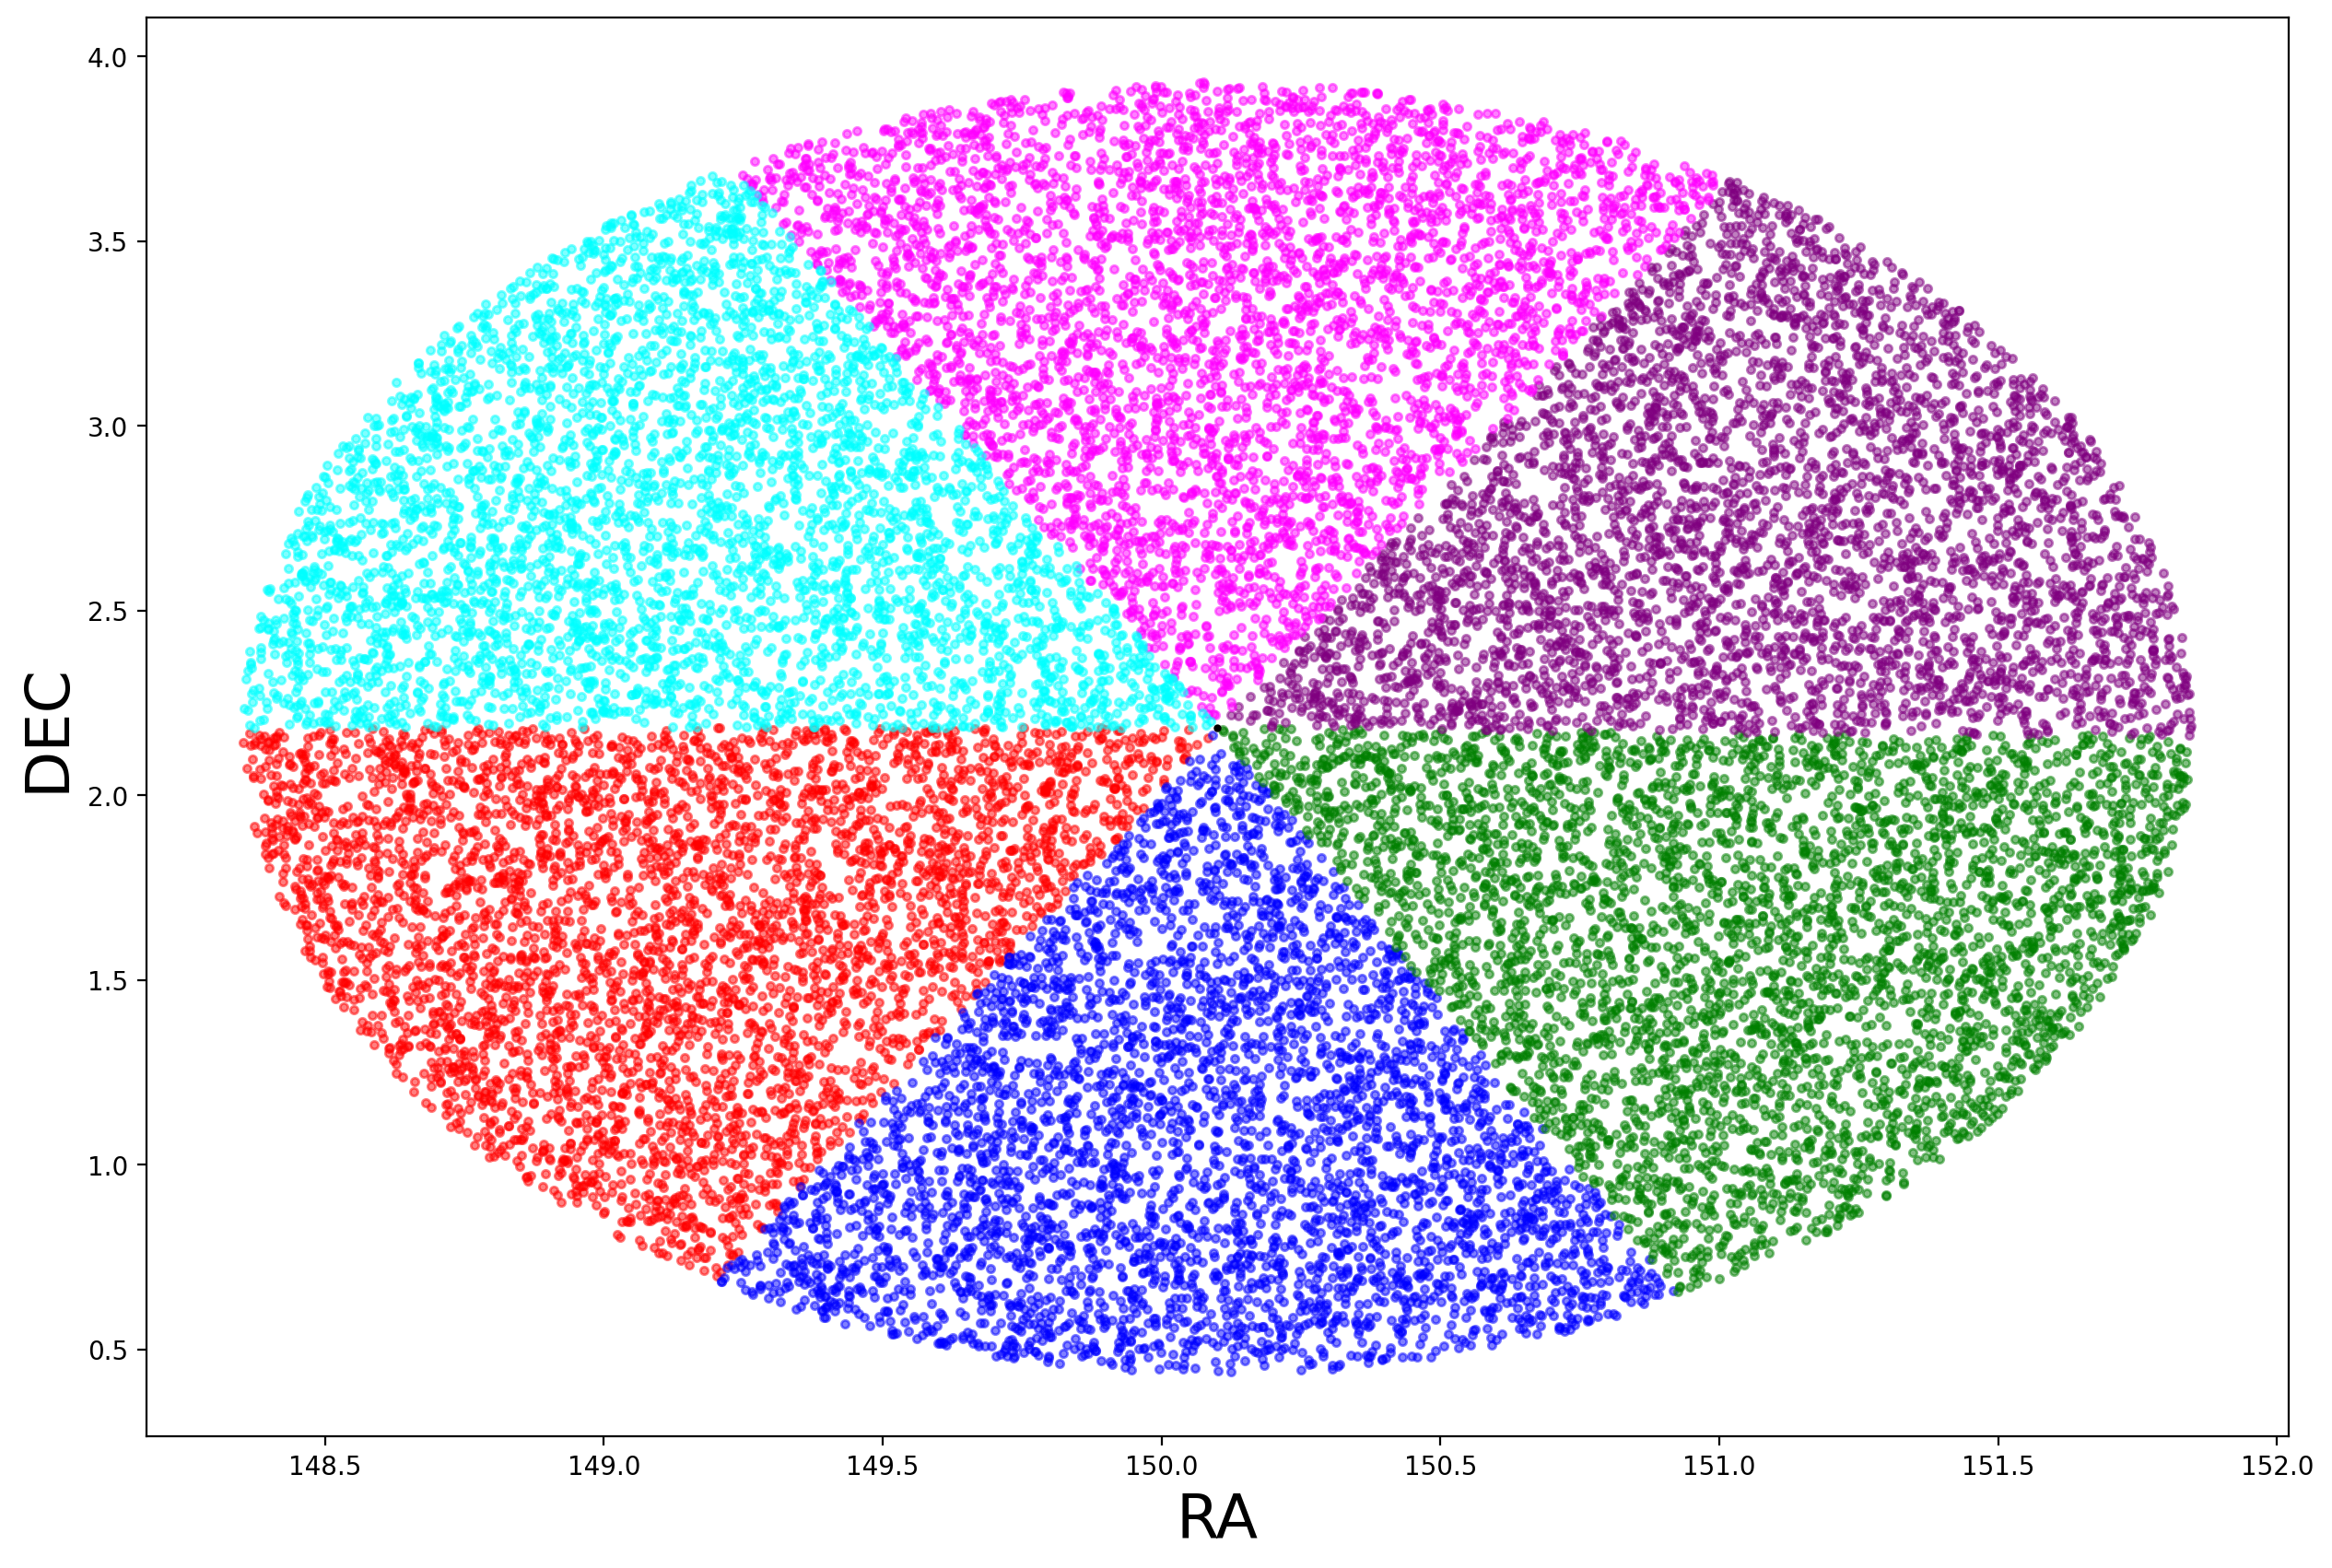

done


In [16]:

def plot_rosette(fin,indsel,rose_id=0,ind_rose=None,sel_id=None,outfile=''):
    import pylab as pl
    dcols=['r','b','g','purple','magenta','cyan','yellow','violet','pink','skyblue']
    ncolor=len(dcols)
    
    if(ind_rose is None):
        ind_rose=assign_rosette(fin,indsel,rosette)
        
    indsel_rose=np.where(ind_rose==rose_id)[0]
    if(indsel.size==0):
        return
    
    if(sel_id is None):
        pl.plot(fin[1]['RA'][indsel_rose],fin[1]['DEC'][indsel_rose],'.',color=dcols[rose_id%ncolor],alpha=0.01)
    else:
        this_sel=sel_id[indsel_rose]
        usel=np.unique(this_sel)
        
        ra=fin[1]['RA'][indsel_rose]
        dec=fin[1]['DEC'][indsel_rose]
        
        for uu, uv in enumerate(usel):
            tid=this_sel==uv
            tcol=dcols[(rose_id+uu)%ncolor]
            pl.plot(ra[tid],dec[tid],'.',color=tcol,alpha=0.5)
            
    pl.plot(rosette[rose_id]['RA'],rosette[rose_id]['DEC'],'ko',markersize=2)
    if(outfile!=''):
        pl.savefig(outfile)
        
    return


pl.figure(figsize=(15,10))
for rose_id in range(0,1):#nrose):
    with F.FITS(randfile) as fin:
        plot_rosette(fin,indsel,rose_id=rose_id,sel_id=jnid)
        
        #ra=fin[1]['RA'][indsel]
        #dec=fin[1]['DEC'][indsel]
        #pl.plot(ra[jnid==-1],dec[jnid==-1],'rx',markersize=20)
    
pl.xlabel('RA',fontsize=24)
pl.ylabel('DEC',fontsize=24)

#pl.ylim([0,4])
#pl.xlim([148,152])
pl.show()
print('done')

In [10]:
ind_min.size

NameError: name 'ind_min' is not defined

(array([[ 8083., 15832.,     0., ..., 16672., 16203.,  7282.],
        [ 8094., 16658.,  6191., ...,     0.,     0.,     0.],
        [ 8068., 16733.,  6252., ...,     0.,     0.,     0.],
        ...,
        [ 7969., 16320.,  6195., ...,     0.,     0.,     0.],
        [ 8175., 15879.,     0., ...,  8617.,  7534.,  1522.],
        [ 8154., 15971.,     0., ...,  7708.,  8626.,  5617.]]),
 array([3.68139935e-05, 1.77168833e-02, 3.53969527e-02, 5.30770220e-02,
        7.07570914e-02, 8.84371607e-02, 1.06117230e-01, 1.23797299e-01,
        1.41477369e-01, 1.59157438e-01, 1.76837507e-01, 1.94517577e-01,
        2.12197646e-01, 2.29877716e-01, 2.47557785e-01, 2.65237854e-01,
        2.82917924e-01, 3.00597993e-01, 3.18278062e-01, 3.35958132e-01,
        3.53638201e-01, 3.71318270e-01, 3.88998340e-01, 4.06678409e-01,
        4.24358478e-01, 4.42038548e-01, 4.59718617e-01, 4.77398686e-01,
        4.95078756e-01, 5.12758825e-01, 5.30438894e-01, 5.48118964e-01,
        5.65799033e-01, 5.83479

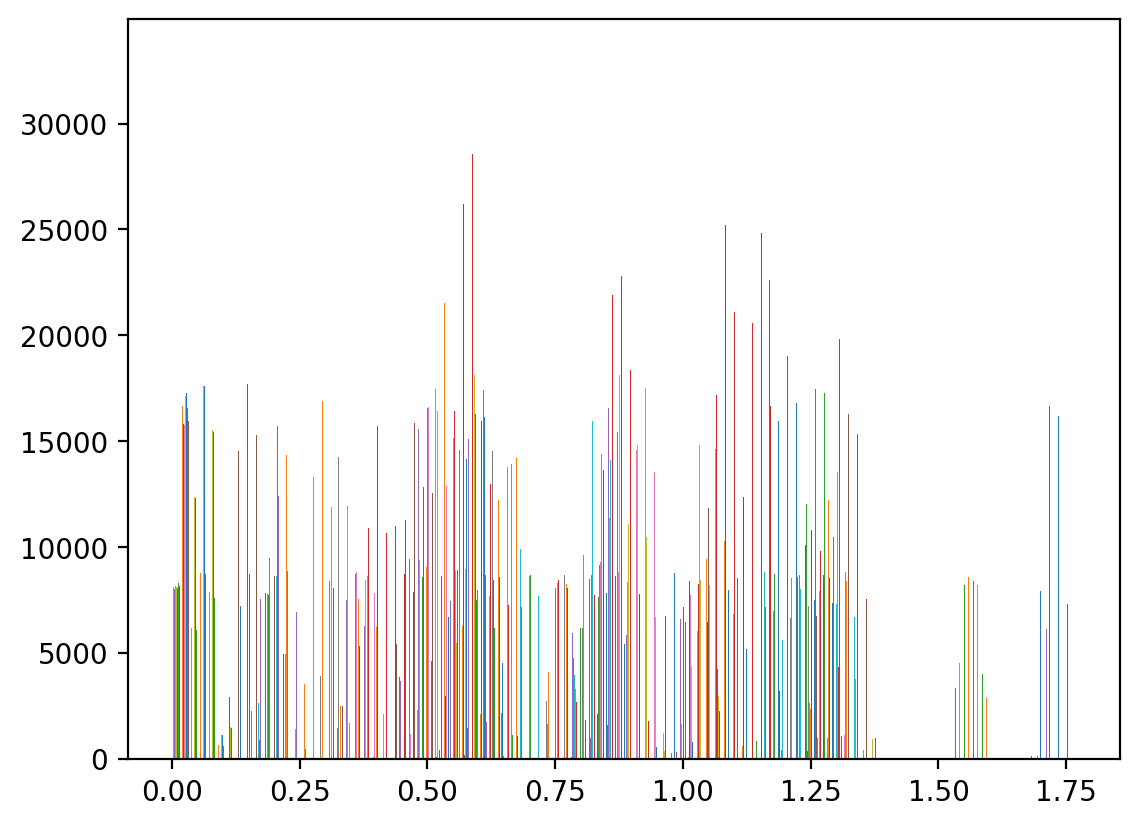

In [50]:
hh=pl.hist(theta,bins=100)

In [157]:
from desitarget.sv3.sv3_targetmask import desi_mask 

In [216]:
with F.FITS(datfile) as fin:
    print(fin[1])


  file: /Users/shock/Documents/Projects/SV3/dark_targets.fits
  extension: 1
  type: BINARY_TBL
  rows: 566779
  column info:
    RELEASE             i2  
    BRICKID             i4  
    BRICKNAME           S8  
    BRICK_OBJID         i4  
    MORPHTYPE           S4  
    RA                  f8  
    RA_IVAR             f4  
    DEC                 f8  
    DEC_IVAR            f4  
    DCHISQ              f4  array[5]
    EBV                 f4  
    FLUX_G              f4  
    FLUX_R              f4  
    FLUX_Z              f4  
    FLUX_IVAR_G         f4  
    FLUX_IVAR_R         f4  
    FLUX_IVAR_Z         f4  
    MW_TRANSMISSION_G
                        f4  
    MW_TRANSMISSION_R
                        f4  
    MW_TRANSMISSION_Z
                        f4  
    FRACFLUX_G          f4  
    FRACFLUX_R          f4  
    FRACFLUX_Z          f4  
    FRACMASKED_G        f4  
    FRACMASKED_R        f4  
    FRACMASKED_Z        f4  
    FRACIN_G            f4  
    FRACIN_R    

Text(0, 0.5, '$\\omega(\\theta)$')

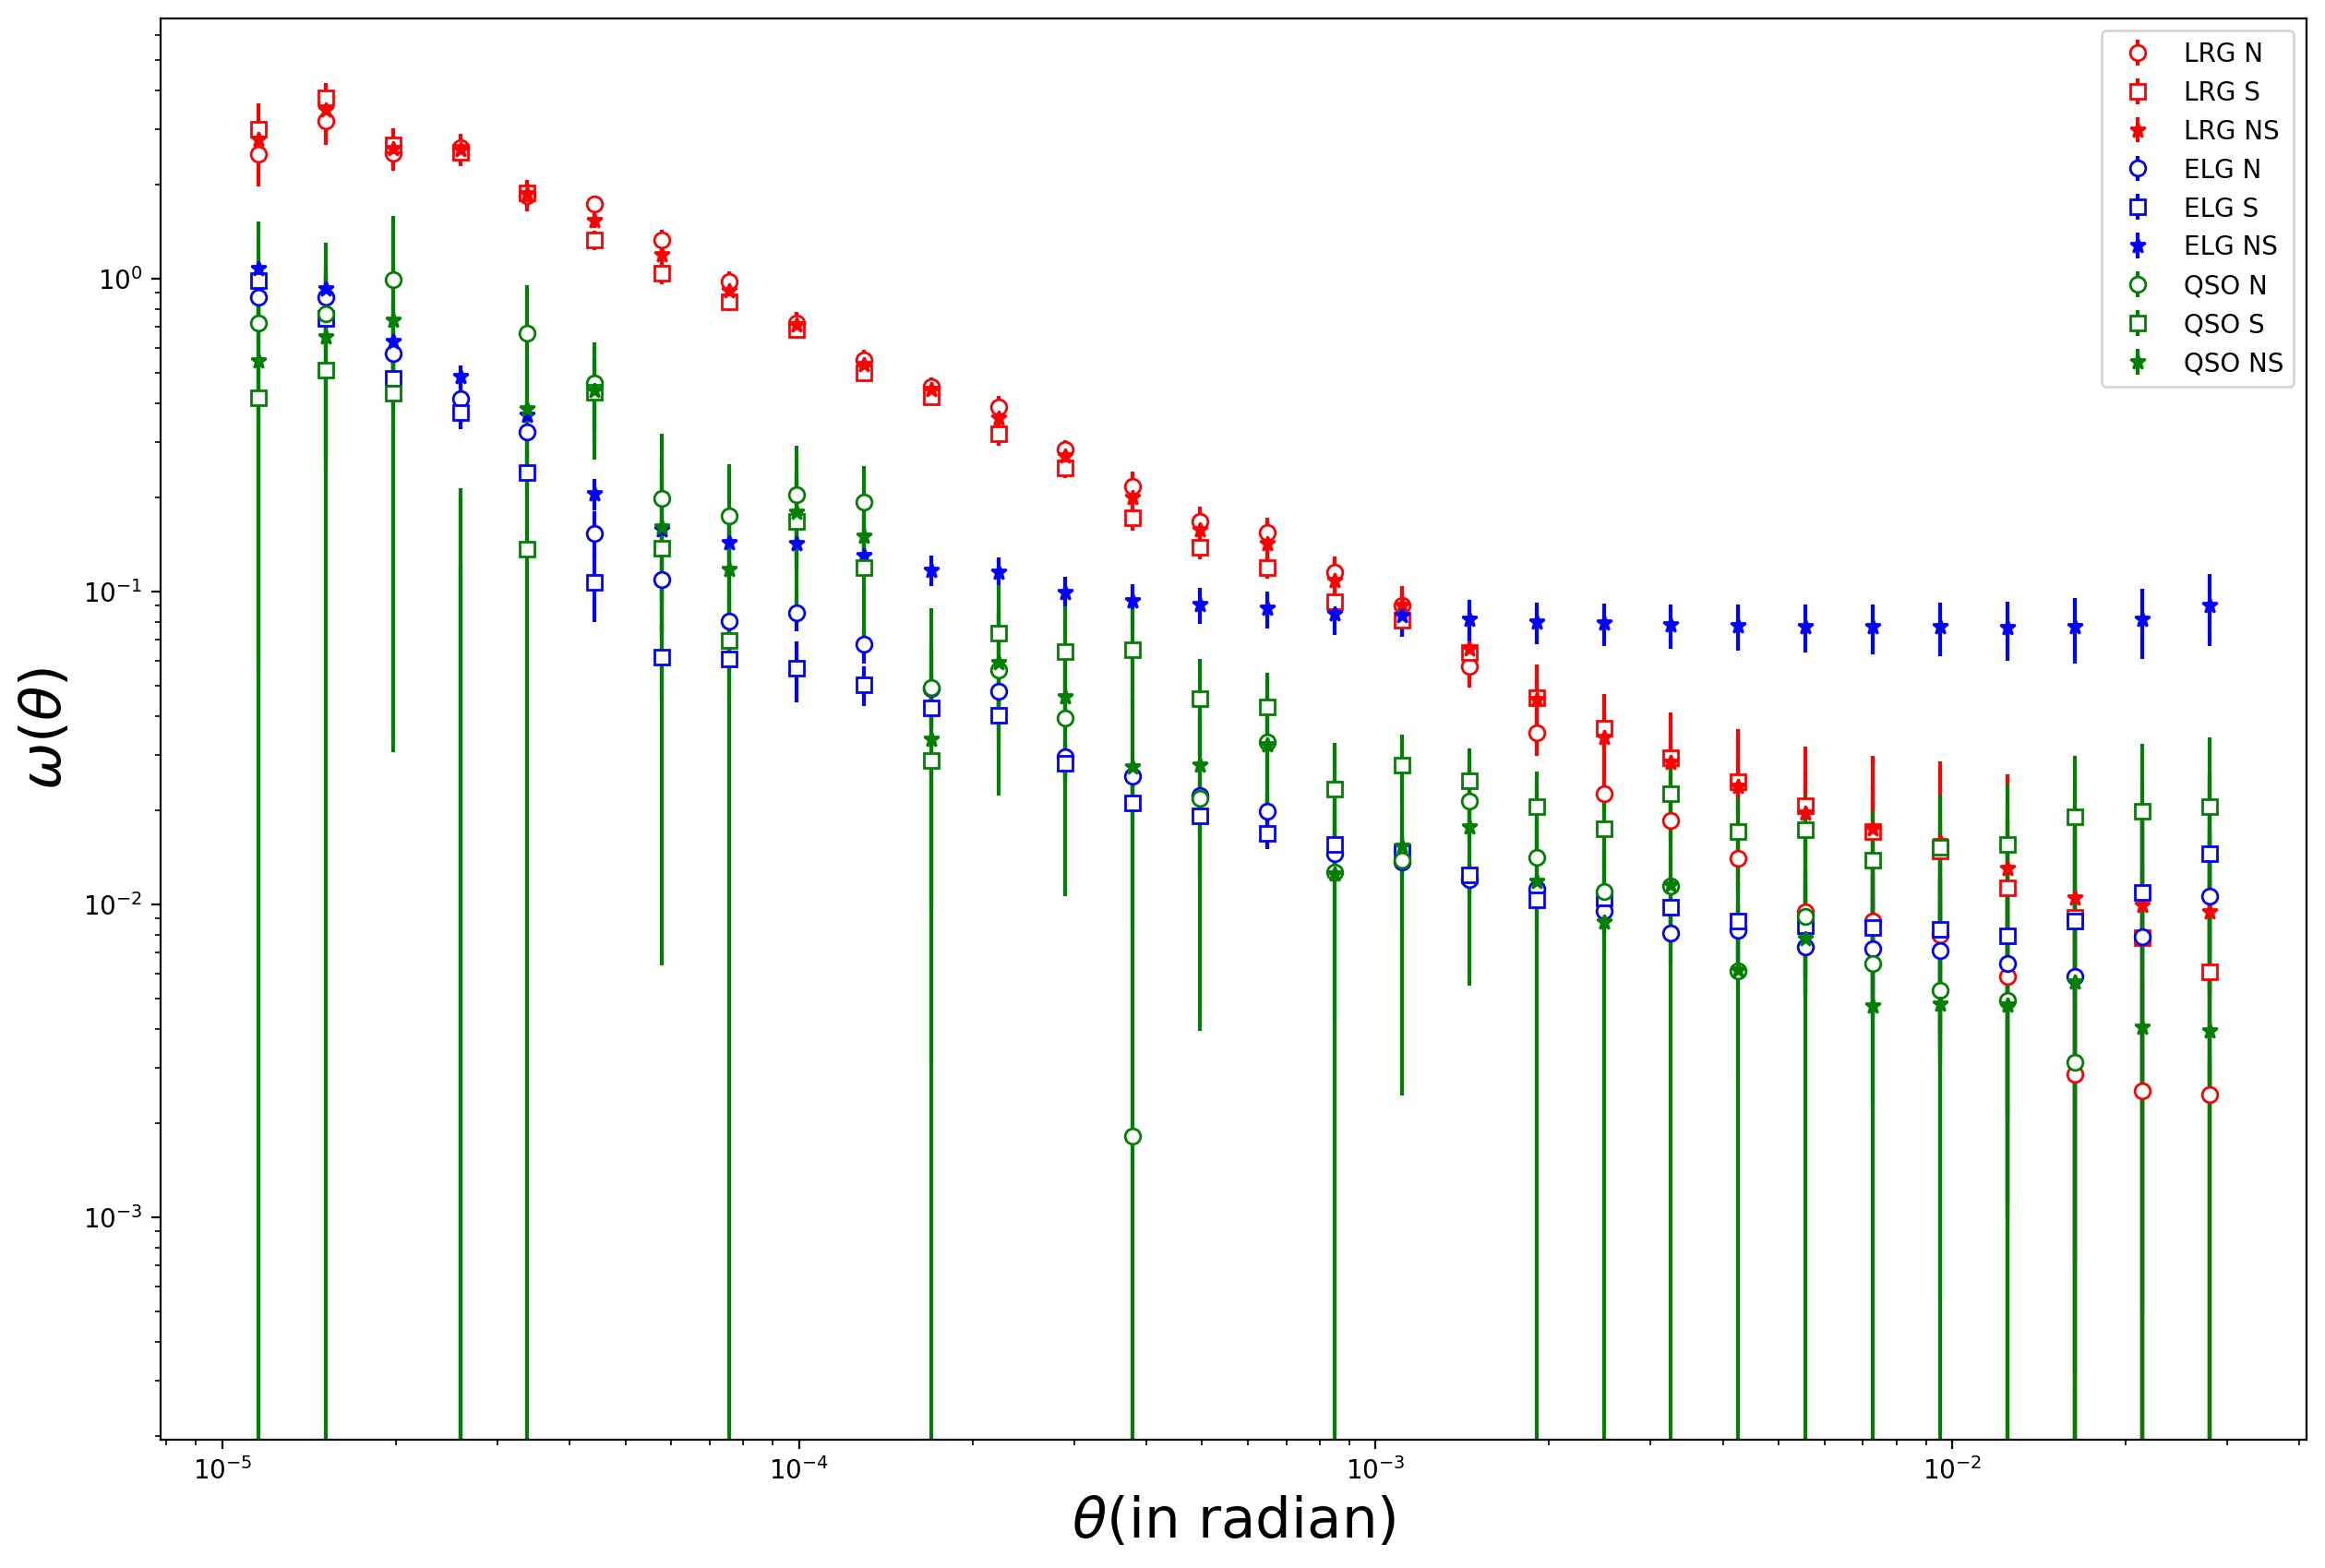

In [242]:
wth_file= lambda tracer,sky,njn:'../example/Wtheta/%s_%sw1-wtheta_DP-logangular-NJN-%d.txt'%(tracer,sky,njn)

njn_dic={'N':48,'S':48,'NS':96}

tmark=['o','s','*']
tcols=['r','b','g']
tmfc=['w','w',None]

pl.figure(figsize=(15,10))
for tt,tracer in enumerate(['LRG','ELG','QSO']):
    for ss,sky in enumerate(['N','S','NS']):
        fname=wth_file(tracer,sky,njn_dic[sky])
        try:
            wth=np.loadtxt(fname)
        except:
            continue
        
        tlab='%s %s'%(tracer,sky)
        pl.errorbar(wth[:,0],wth[:,1],yerr=wth[:,2],fmt=tmark[ss],color=tcols[tt],mfc=tmfc[ss],label=tlab)
        
pl.legend()
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$\theta $(in radian)',fontsize=22)
pl.ylabel(r'$\omega(\theta)$',fontsize=22)

In [235]:
!ls ../example/Wtheta/

ELG_NSw1-wtheta_DP-logangular-NJN-96.txt
ELG_Nw1-wtheta_DP-logangular-NJN-48.txt
ELG_Sw1-wtheta_DP-logangular-NJN-48.txt
LRG_NSw1-wtheta_DP-logangular-NJN-96.txt
LRG_Nw1-wtheta_DP-logangular-NJN-48.txt
LRG_Sw1-wtheta_DP-logangular-NJN-48.txt
test_desi_sv3-wtheta_DP-logangular-NJN-48.txt
test_desi_sv3-wtheta_DP-logangular-NJN-90.txt
test_desi_sv3-wtheta_DP-logangular-NJN-96.txt


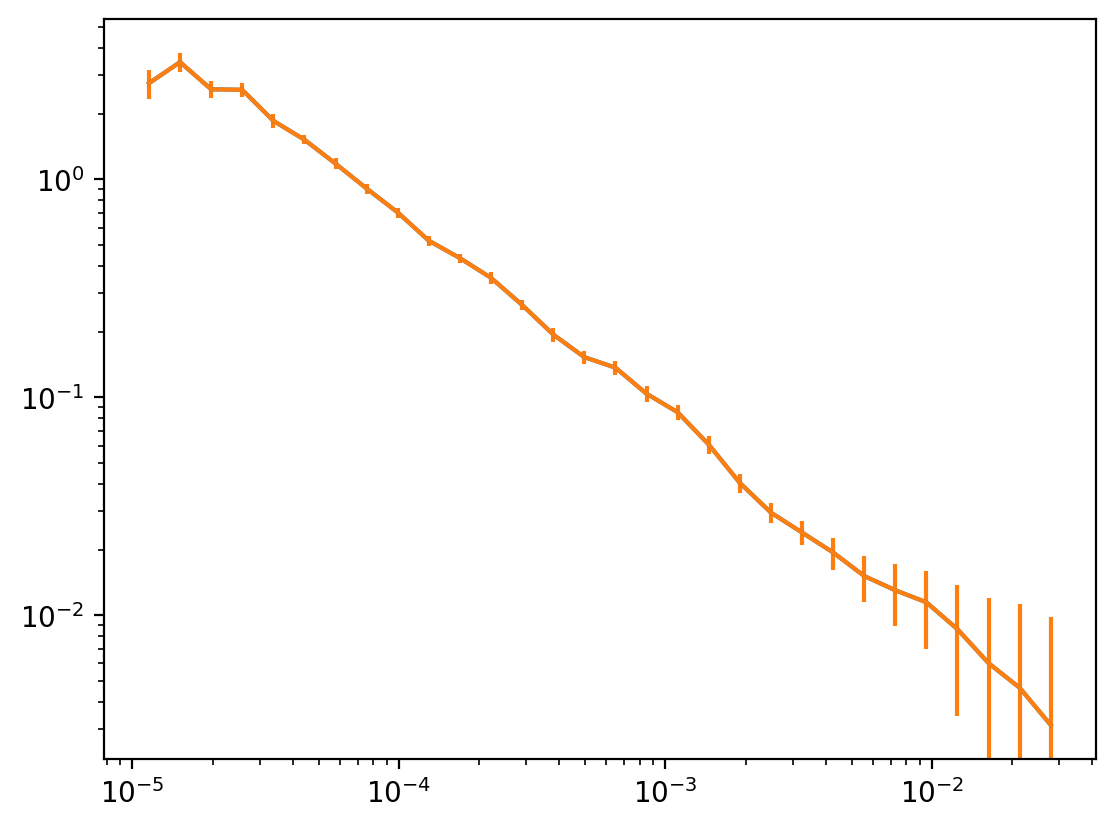

In [222]:
pl.plot(wtheta[:,0],wtheta[:,1])
pl.errorbar(wtheta[:,0],wtheta[:,1],yerr=wtheta[:,2])
pl.xscale('log')
pl.yscale('log')

In [228]:
from configobj import ConfigObj
filename='../config_desi_sv3/angular.ini'
config = ConfigObj(filename)

In [229]:
config

ConfigObj({'Cinterpolation': 'True', 'catname': 'sv3_desi', 'data': '/Users/shock/Documents/Projects/SV3/dark_targets.fits', 'rand': '/Users/shock/Documents/Projects/SV3/alltilesnofa.fits', 'tile_file': '/Users/shock/Documents/Projects/SV3/tiles-sv3.ecsv', 'filetype': 'fits', 'coord': 'sky', 'randfactor': '10', 'wang_up_file': '', 'bit_perlong': '31', 'theta_max': '0.025', 'noRR': 'True', 'sampmode': '7', 'samplim': ['-5', '-1.5'], 'nbins': '30', 'njn_per_rose': '6', 'njn': '96', 'H0': '67.6', 'omM': '0.315', 'nproc': '4', 'plots': '0', 'jnfile': '', 'outfile': 'example/PairCount/test_desi_sv3', 'sv3_desi': {'PROGRAM': 'DARK', 'tracer': 'LRG', 'wtag': 'w1'}})

In [231]:
for ii in range(0,0,-1):
    print(ii)